# The Vols Static Random & Volz NE Model (2007)

This notebook will show an implementation of the Volz SIR dynamics in random networks & Volz Neighbour Exchange SIR model. I will explain each step of the ordinary differential equations as well as explain the probability generating functions. 

Static Random paper; https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7080148/pdf/285_2007_Article_116.pdf

This model assumes that each individuals number of current contacts stays the same but that the identity of the contacts change over time, they change at a steady rate $\rho$.


https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7080148/pdf/285_2007_Article_116.pdf

https://royalsocietypublishing.org/doi/10.1098/rspb.2007.1159

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2291166/pdf/rspb20071159.pdf

https://www.researchgate.net/publication/247604013_Correction_for_Volz_and_Meyers_Susceptible-infected-recovered_epidemics_in_dynamic_contact_networks

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7080148/pdf/285_2007_Article_116.pdf

https://royalsocietypublishing.org/doi/10.1098/rspb.2007.1159

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import scipy as sp
import scipy.integrate as sp_int
import matplotlib.pyplot as plt
import math
import numpy as np
import networkx as nx

# Probability Generating Function

An indepth look at probability generating functions can be found here: https://arxiv.org/abs/1803.05136

In order to express the degree distribution, and other values of the network, in a functional way, Newman devleoped the idea of using Probability Generating Functions (PGF's). 

Probability Generating Functions can be written as:
$$
g(x) = p_{0} + p_{1}x + p_{2}x^2 + p_{3}x^3 + ... p_{n}x^n
$$

Alternatively it can be written as 

$$
G_{0}(x) = \sum_{k = 0}^{\infty}p_{k}x^k
$$

$x$ is used to find the associated value of k (degree) within a specific networks degree distribution.

The first derivate of a PGF evaluated at $x = 1$ gives the average value of k. For example the average degree of a vertex in a distribution would be found by:

$$
G_{0}'(1) = <K> = \sum_{k}^{}kp_{k}
$$

PGF's are connected to the moments of the distributions, these functions prove beneficial not only for gathering information about properties of vertices but also the edges.

# How the Probability Generating Function works in practice

Consider the probability of a node being infected, say $\lambda$, is compounded geometrically according to the node's degree. Then the probability of a degree $k$ node being susceptible is $(1 - \lambda)^{k}$, that is, the probability of not being infected along any of $k$ connections. If the hazard is identical for all nodes, the cumulative epidemic incidence ( the fraction of nodes infected or recovered) will be:

$J = 1 - [p_{0}(1-\lambda)^{0} + p_{1}(1-\lambda)^{1} + p_{2}(1-\lambda)^{2} + ... $

$J = 1 - g(1-\lambda)$

Refernce: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7080148/pdf/285_2007_Article_116.pdf

Below I have written out the probability generating function for a network with P(1) = 0.5 and P(3) = 0.5 distribution alongside its first and second derivative

The degree distribution will have density pk, which is the probability that a node chosen uniformly at random has k concurrent contacts.

An example of a network with P(1) = 0.5 and P(3) = 0.5

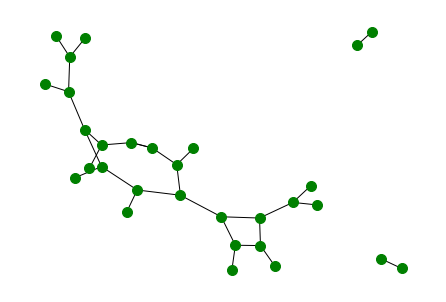

In [6]:
G = nx.configuration_model([3]*15 + [1]*15, seed = 8)
nx.draw(G, pos = nx.spring_layout(G, seed=2), 
        node_size  = 100,
       node_color = 'green')

# Static Semi Random Network ODE

The static semi random network equation models an SIR on semi random network with the degree distribution provided in the probability generating function.

$\dot{\theta} = -rp_{I} \theta$

$\dot{p_{I}} = r p_{S} p_{I} \theta \frac{g''(\theta)}{g'(\theta)} -  r p_{I} (1-p_{I} ) - p_{I} \mu$

$\dot{p_{S}} = r p_{S} p_{I} ( 1- \theta \frac{g''(\theta)}{g'(\theta)}$



$\dot{S} = -rp_{I}\theta g'(\theta)$

$\dot{I} = r p_{I} \theta g'(\theta) - \mu I $

In [7]:
def calc_g (x):
    return 0.5*x + 0.5*x**3
    
def calc_g1( x): 
    return 0.5 + 3*0.5*x**2
    
def calc_g2( x):
    return 3*0.5*2*x

In [8]:
r = 0.7 # force of infection (trasnsmission rate
mu = 0.2 # reocvery rate
epsilon = 0.001
time = list(range(0,100))
# time = np.linspace(0,200,0.1)
init = [1 - epsilon, # theta
       epsilon / (1 - epsilon), #force of infection 
       (1 - 2*epsilon)/(1 - epsilon), # represents the probability that an arc with a susceptible ego has a susceptible alter
       calc_g( 1 - epsilon), #
       1 - calc_g( 1- epsilon) # 
       ]

In [9]:
init

[0.999,
 0.001001001001001001,
 0.998998998998999,
 0.9980014994999999,
 0.0019985005000000555]

$$
p_{I} = \frac{M_{SI}}{M_{S}}\\
p_{S} = \frac{M_{SS}}{M_{S}}\\
S = g(\theta)
$$

In [10]:
def static_semi_random(x, t, rr, mm, calc_g, calc_g1, calc_g2):
    #x[0] - theta
    # x[1] pi
    #x[2] ps
    # x[3] s
    #x[4] I
    
    y=list(range(5))#zeros(6);
    
    y[0]= -rr * x[1] * x[0] 
    
    y[1]= rr * x[2] * x[1] * x[0] * (calc_g2(x[0])/calc_g1(x[0])) - rr * x[1] * (1 - x[1]) - x[1] * mm
    
    y[2]= rr * x[2] * x[1] * ( 1- x[0] * (calc_g2(x[0]) / calc_g1(x[0]) ) )
    
    y[3]= -rr * x[1] * x[0] * calc_g1(x[0])
    y[4] = rr * x[1] * x[0] * calc_g1(x[0]) - mm * x[4]
    return(y)

In [11]:
out=sp_int.odeint(static_semi_random, init, time, args=(r,mu, 
                                          calc_g,calc_g1,calc_g2))

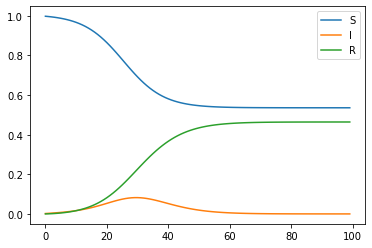

In [12]:
# plt.plot(out[:,0])
# plt.plot(out[:,1])
# plt.plot(out[:,2])
plt.plot(out[:,3], label = 'S')
plt.plot(out[:,4], label = 'I')
plt.plot(1 - out[:,3] - out[:,4], label = 'R')
plt.legend()


The simultaneous epidemic and network dynamics described above collectively determine the NE model. An even more realistic model would allow the number k of concurrent contacts of a node to vary stochastically, but the current model offers a valuable first step towards understanding epidemiological processes on dynamic host networks.



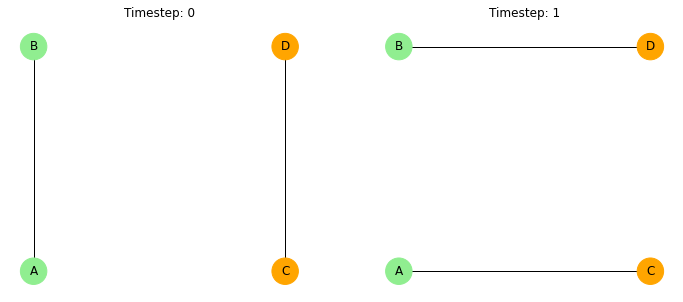

In [13]:
fig, ax = plt.subplots(ncols = 2, figsize = (12,5))
nx.draw(nx.from_edgelist([['A','B'],
                 ['C','D']]), pos = {'A':(0.1, 0.1),
                                    'B':(0.1, 0.2),
                                    'C':(0.2,0.1),
                                    'D':(0.2,0.2)},
       node_size = 700,
       node_color = {'A': "lightgreen", 'B': "lightgreen", 'C': "orange", 'D': "orange"}.values(),
       with_labels = True,
       ax = ax[0])

ax[0].set_title('Timestep: 0')

nx.draw(nx.from_edgelist([['A','C'],
                 ['B','D']]), pos = {'A':(0.1, 0.1),
                                    'B':(0.1, 0.2),
                                    'C':(0.2,0.1),
                                    'D':(0.2,0.2)},
       node_size = 700,
       node_color = {'A': "lightgreen",'C': "orange",'B': "lightgreen",'D': "orange"}.values(),
       with_labels = True,
       ax = ax[1])

ax[1].set_title('Timestep: 1')
plt.show()

In [14]:
type(nx.from_edgelist([['A','C'],
                 ['B','D']]))

networkx.classes.graph.Graph

Since the degrees of the nodes dont change timestep to timestep the overall degree distribution is preserved, the infection will be assumed to still spread at a constant rate of of T and recover at the rate of $\mu$.

As $\rho$ approaches $\infty$  the model approaches a mass action model, (the general SIR compartmental model), because the rate of mixing is so high that all individuals are interacting with each other. The probability of being connected to an infectious node becomes proportional to the number of nodes in each state.


The intials conditions for the model are derived as such

$$
\theta(t = 0) = 1 - \epsilon
$$

$$
p_{I}(t = 0) = \frac{M_{SI}}{M_{S}} = \frac{ \epsilon}{1 -  \epsilon}
$$

$$
p_{S}(t = 0) =  \frac{M_{SS}}{M_{S}}= \frac{1 - 2\epsilon}{1 -  \epsilon}
$$

$$
S(t = 0) = g(1 - \epsilon)
$$

$$
M_{I} (t = 0) = \epsilon
$$

$$
I(t = 0) = 1 - g(1 - \epsilon)
$$

Dictionary

$M_{SI}$ - Denotes the fraction of arcs with a susceptible ego and an infectious alter

$M_{SS}$ - Denotes the fraction of arcs with a susceptible ego and an susceptible alter

$M_{S}$ - Denotes the fraction of arcs with a susceptible ego and an alter of any state 

$\theta$ The fraction of degree one nodes that remain susceptible at time t

$p_{I}$ The probability that an arc with a susceptible ego has an infectious alter, $\frac{M_{SI}}{M_{S}}$

$p_{S}$ The probability that an arc with a susceptible ego has a susceptible alter, $\frac{M_{SS}}{M_{S}}$

$S$ The fraction of nodes which remain susceptible at time t

$M_{I}$- Denotes the fraction of arcs with an infecetious ego and an alter of any state 

$I$ Proportion of Infected


# the NE Equation

$$
\dot{\theta} = -r p_{I} \theta
$$

$$
\dot{p_{I}} = rp_{S}\rho_{I}\theta \frac{g''(\theta)}{g'(\theta)} - rp_{I} (1 - p_{I}) - p_{I}\mu+\rho(M_{I} - p_{I})
$$

$$
\dot{ p_{S}} = rp_{S}p_{I}(1 - \theta\frac{g''(\theta)}{g'(\theta)} + \rho(\frac{\theta g'(\theta)}{g'(1)} - p_{S})
$$

$$
\dot{S} = -rp_{I}\theta g'(\theta)
$$

$$
\dot{M_{I}} = -\mu M_{I} + rp_{I}(\frac{\theta^2 g''(\theta) + \theta g'(\theta)}{g'(1)})
$$

$$
\dot{I} = rp_{I} \theta g'(\theta) - \mu I
$$

In [22]:
def derv(x,t,lam,rr,mm,pp, calc_g, calc_g1, calc_g2):
    #y[0]= change of theta 
    #y[1]= change of p_infec 
    #y[2]= change of p_suscep 
    #y[3]= proportion of S 
    #y[4]= change of M_I 
    #y[5]= change of I
    y=list(range(6))#zeros(6);
    y[0]= -rr *x[1] *x[0] 
    y[1]= rr *x[2] * x[1] * x[0] * calc_g2(x[0])/calc_g1(x[0]) - rr *x[1] * (1-x[1])-x[1]*mm+pp*(x[4]-x[1]) 
    y[2]=rr*x[2]*x[1]*(1-x[0]*calc_g2(x[0])/calc_g1(x[0]))+pp*(x[0]*calc_g1(x[0])/calc_g1(1)-x[2])
    y[3]=-rr*x[1]*x[0]*calc_g1(x[0]) 
    y[4]=-mm*x[4]+rr*x[1]*(x[0]**2*calc_g2(x[0])+x[0]*calc_g1(x[0])/calc_g1(1)) 
    y[5]=rr*x[1]*x[0]*calc_g1(x[0])-mm*x[5]
    return(y)

In [23]:
# lamda = 1.5w_pgf.powerlaw_p_vec(2.218, 75)
lamda = None
r = 0.2 # force of infection (trasnsmission rate
mu = 0.1 # reocvery rate
ro = 0.25 # how fast people change partners (mixing rate)
epsilon = 0.001
time = list(range(0,200))
# time = np.linspace(0,200,0.1)
init = [1 - epsilon, # theta
       epsilon / (1 - epsilon), #force of infection 
       (1 - 2*epsilon)/(1 - epsilon), # represents the probability that an arc with a susceptible ego has a susceptible alter
       calc_g( 1 - epsilon), #
       epsilon, #
       1 - calc_g( 1- epsilon) # 
       ]

In [24]:
out=sp_int.odeint(derv, init, time, args=(lamda,r,mu,ro, 
                                          calc_g,calc_g1,calc_g2))

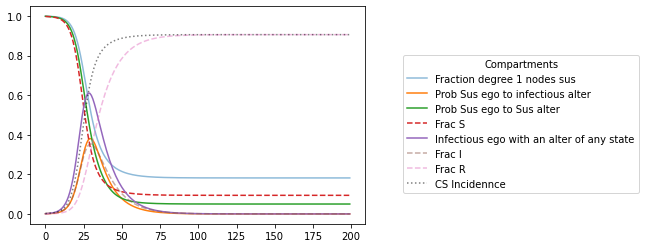

In [25]:
plt.plot(out[:,0], alpha =0.5, label = 'Fraction degree 1 nodes sus') # change of theta
plt.plot(out[:,1], label = 'Prob Sus ego to infectious alter',
        )#change of p_infec 
plt.plot(out[:,2], label = 'Prob Sus ego to Sus alter')# change of p_suscep 
plt.plot(out[:,3], label = 'Frac S', ls = '--') #proportion of S
plt.plot(out[:,4], label = 'Infectious ego with an alter of any state')# change of M_I 
plt.plot(out[:,5], alpha = 0.5, label = 'Frac I', ls = '--') # change of I
# recovered
plt.plot(1 - (out[:,5]+out[:,3]), alpha = 0.5, label= 'Frac R', ls = '--')
plt.plot(1 - (out[:,5]+out[:,3]) + out[:,5], alpha = 0.5, c = 'black',label= 'CS Incidennce', ls = ':')
plt.legend(title = 'Compartments', bbox_to_anchor = (1.1,0.8))
# plt.yscale('log')
plt.show()

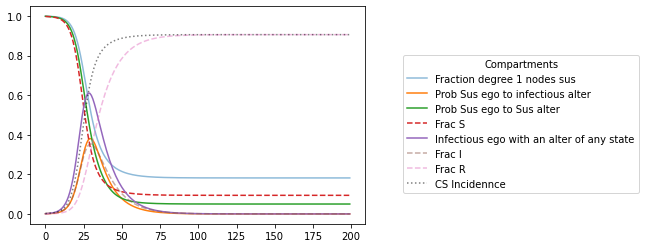

In [26]:
plt.plot(out[:,0], alpha =0.5, label = 'Fraction degree 1 nodes sus') # change of theta
plt.plot(out[:,1], label = 'Prob Sus ego to infectious alter',
        )#change of p_infec 
plt.plot(out[:,2], label = 'Prob Sus ego to Sus alter')# change of p_suscep 
plt.plot(out[:,3], label = 'Frac S', ls = '--') #proportion of S
plt.plot(out[:,4], label = 'Infectious ego with an alter of any state')# change of M_I 
plt.plot(out[:,5], alpha = 0.5, label = 'Frac I', ls = '--') # change of I
# recovered
plt.plot(1 - (out[:,5]+out[:,3]), alpha = 0.5, label= 'Frac R', ls = '--')
plt.plot(1 - (out[:,5]+out[:,3]) + out[:,5], alpha = 0.5, c = 'black',label= 'CS Incidennce', ls = ':')
plt.legend(title = 'Compartments', bbox_to_anchor = (1.1,0.8))
plt.show()

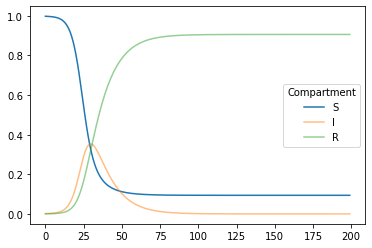

In [27]:
# plt.plot(pop_tap[:,0], alpha =0.5) # change of theta
# plt.plot(pop_tap[:,1])#change of p_infec 
# plt.plot(pop_tap[:,2]) change of p_suscep 
plt.plot(out[:,3], label = 'S') #proportion of S
# plt.plot(pop_tap[:,4], alpha = 0.5) change of M_I 
plt.plot(out[:,5], alpha = 0.5, label = 'I') # change of I
# recovered
plt.plot(1 - (out[:,5]+out[:,3]), alpha = 0.5, label= 'R')
plt.legend(title = 'Compartment')

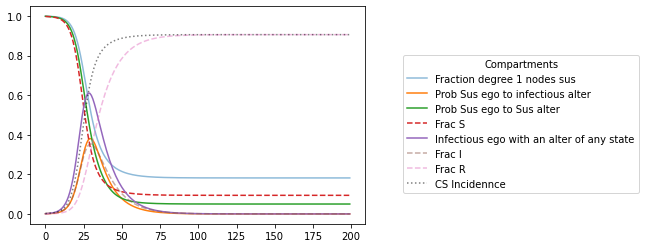

In [28]:
plt.plot(out[:,0], alpha =0.5, label = 'Fraction degree 1 nodes sus') # change of theta
plt.plot(out[:,1], label = 'Prob Sus ego to infectious alter',
        )#change of p_infec 
plt.plot(out[:,2], label = 'Prob Sus ego to Sus alter')# change of p_suscep 
plt.plot(out[:,3], label = 'Frac S', ls = '--') #proportion of S
plt.plot(out[:,4], label = 'Infectious ego with an alter of any state')# change of M_I 
plt.plot(out[:,5], alpha = 0.5, label = 'Frac I', ls = '--') # change of I
# recovered
plt.plot(1 - (out[:,5]+out[:,3]), alpha = 0.5, label= 'Frac R', ls = '--')
plt.plot(1 - (out[:,5]+out[:,3]) + out[:,5], alpha = 0.5, c = 'black',label= 'CS Incidennce', ls = ':')
plt.legend(title = 'Compartments', bbox_to_anchor = (1.1,0.8))
plt.show()